# What is this notebook about?

We are quants who want to trade the SPY ETF (S&P 500). We want to develop a trading strategy for this purpose. In this notebook, we are going to come up with and test such a trading strategy.

Our trading strategy - broadly speaking - is going to involve predicting the SPY ETF returns and taking a position based on the predicted return. In order to predict the SPY ETF returns, we will be using several sector ETF returns as features. These are SPDR ETFs that slice the U.S. equity market (the S&P 500 universe) by sector. Together, they’re a standard way to decompose the market into economically meaningful blocks.

| Ticker  | Sector                 | What It Represents                        | Typical Macro / Quant Interpretation               |
| ------- | ---------------------- | ----------------------------------------- | -------------------------------------------------- |
| **SPY** | Broad Market           | S&P 500 (all sectors, cap-weighted)       | Market factor / equity beta                        |
| **XLB** | Materials              | Chemicals, metals, construction materials | Pro-cyclical; inflation & global growth sensitive  |
| **XLE** | Energy                 | Oil, gas, energy services                 | Commodity-driven; inflation & geopolitics exposure |
| **XLF** | Financials             | Banks, insurers, asset managers           | Rate & credit-cycle sensitive                      |
| **XLI** | Industrials            | Manufacturing, transport, defense         | Pro-cyclical; expansion indicator                  |
| **XLK** | Technology             | Software, hardware, semiconductors        | Growth-oriented; rate-sensitive via discounting    |
| **XLP** | Consumer Staples       | Food, beverages, household goods          | Defensive; recession-resilient                     |
| **XLU** | Utilities              | Regulated electric & gas utilities        | Defensive; bond-like, rate-sensitive               |
| **XLV** | Health Care            | Pharma, devices, health services          | Semi-defensive; policy/regulatory risk             |
| **XLY** | Consumer Discretionary | Retail, autos, consumer services          | Highly cyclical; risk-on indicator                 |

So, in summary, our trading strategy is going to involve the coupling of a regression that aims to predict the SPY returns and a position sizer that takes in the predicted SPY return and outputs the position we should take. We will try many regression models and aim to narrow it down to one before we test it using a testing data set.

Here is the workflow I will follow:

1. <b>Imports</b>
2. <b>Downloading Data</b>
3. <b>Data Cleaning</b>
4. <b>Exploratory Data Analysis + In-Sample Excellence</b>
5. <b>Walk-Forward Validation</b>
6. <b>Conclusion & Next Steps</b>



## 1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from itertools import product

import empyrical as emp

from scipy.stats import skew, kurtosis, norm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as rmse, mean_absolute_error as mae, r2_score

## 2. Downloading Data

In [2]:
data_path = os.path.join(os.getcwd(), "data.xlsx")
data_path

'/Users/abhayagarwal/Desktop/Books/Quantitative Finance/SingleTargetPredictor/data.xlsx'

In [3]:
target_etfs = 'SPY'
feature_etfs = ['XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLE', 'XLI', 'XLB', 'XLU'] #Sector ETFs as features
etf_list = [target_etfs] + feature_etfs
start_date = '2020-01-01'

if os.path.exists(data_path):
    print(f"\nData already exists in {data_path}\n")
    all_data = pd.read_excel(data_path)
else:
    all_data = yf.download(etf_list, start=start_date, auto_adjust=True)
    all_data.to_excel(data_path)


Data already exists in /Users/abhayagarwal/Desktop/Books/Quantitative Finance/SingleTargetPredictor/data.xlsx



In [4]:
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
all_data

,Price,Close,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,High,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Low,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Open,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Volume,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50
0,Ticker,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00,297.699005,26.884277,23.508688,27.785069,75.361717,44.349255,53.2882,26.448549,92.685555,60.27602,297.71735,27.433477,23.543612,27.785069,75.361717,44.349255,53.816988,26.838168,92.830762,60.27602,295.554718,26.853274,23.372866,27.534752,74.290438,43.841131,53.143212,26.349071,92.023065,59.710827,296.480254,27.384759,23.454358,27.615211,74.490169,43.92661,53.816988,26.82988,92.721856,59.943552,59151200,14714800,23889400,28843300,16121300,26567000,14460700,38215400,6277400,12591000
3,2020-01-03 00:00:00,295.444763,26.450235,23.438845,27.490053,75.216461,43.85062,53.202908,26.502428,91.877869,59.763077,296.5719,26.769125,23.79198,27.606271,75.307246,44.154548,53.433187,26.59776,92.404235,59.938806,294.244329,26.441377,23.322425,27.347016,74.435698,43.698658,52.95557,26.407096,91.160923,59.473356,294.299309,26.609681,23.722129,27.427474,74.499248,43.703408,53.092032,26.46927,91.614685,59.511353,77709700,24846400,59005800,51363600,17571300,30023600,26388900,35978600,8247500,11192800
4,2020-01-06 00:00:00,296.571869,26.335083,23.621225,27.472172,75.24369,43.955097,53.313786,26.527306,92.4496,59.929314,296.654338,26.498959,23.741525,27.490052,75.252771,44.002588,53.382018,26.60606,92.476825,59.943562,293.56617,26.312938,23.438838,27.230795,74.689893,43.333003,53.032335,26.427828,91.433169,59.250134,293.685302,26.374944,23.52033,27.239735,74.86239,43.413732,53.126153,26.469277,91.460394,59.326128,55653900,31528800,44916200,27956100,16153100,15630000,22541700,20889000,6441800,12823200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,2026-01-06 00:00:00,691.809998,47.5,45.639999,56.400002,162.020004,146.649994,77.470001,42.91,158.089996,121.07,692.320007,47.630001,47.060001,56.52,162.160004,146.770004,77.690002,42.959999,158.330002,121.260002,687.780029,46.689999,45.529999,55.990002,159.179993,144.630005,77.139999,42.52,155.139999,119.440002,687.929993,46.73,47,56.040001,159.440002,145.210007,77.339996,42.75,155.139999,119.529999,69273800,18351400,69568200,38950800,12757200,14985700,17108100,21861800,17783800,17759400
1513,2026-01-07 00:00:00,689.580017,46.68,45.130001,55.610001,158.970001,146.529999,76.620003,41.869999,159.660004,120.900002,693.960022,47.560001,45.82,56.34,162.600006,147.380005,77.690002,42.970001,160.589996,122.129997,689.320007,46.630001,45.080002,55.540001,158.869995,146.039993,76.599998,41.740002,158.539993,120.900002,692.190002,47.34,45.82,56.23,162.490005,146.529999,77.559998,42.950001,158.539993,121.260002,75588300,16963400,42739200,44720900,12333000,13957100,18977200,27613300,14505700,11327700
1514,2026-01-08 00:00:00,689.51001,47.5,46.549999,55.900002,160.169998,144.240005,78.440002,41.990002,158.119995,122.919998,690.619995,47.630001,46.849998,56.25,161.360001,145.929993,78.730003,42.290001,160.5,123.139999,687.48999,46.27,45.220001,55.41,159.759995,143.5,76.5100

## 3. Data Cleaning
This data clearly requires a lot of touch-ups. A cursory glance reveals that we must

* filter out the closing values, which is what we need
* make the first row the column headers
* make the date column the index and ensure that it is set to `datetime` type
* fix any other column data types
* convert the closing values DataFrame into a log returns DataFrame

In [5]:
print(all_data.shape)
print(all_data.columns)

(1517, 51)
Index(['Price', 'Close', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'High', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Low', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Open', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Volume',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49',
       'Unnamed: 50'],
      dtype='object')


### a. Choose the right subset of data (only closing values)

In [6]:
column_mask = ["Price", "Close"] + [f"Unnamed: {i}" for i in range(2, 11)]
all_data = all_data[column_mask]
all_data

,Price,Close,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Ticker,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00,297.699005,26.884277,23.508688,27.785069,75.361717,44.349255,53.2882,26.448549,92.685555,60.27602
3,2020-01-03 00:00:00,295.444763,26.450235,23.438845,27.490053,75.216461,43.85062,53.202908,26.502428,91.877869,59.763077
4,2020-01-06 00:00:00,296.571869,26.335083,23.621225,27.472172,75.24369,43.955097,53.313786,26.527306,92.4496,59.929314
...,...,...,...,...,...,...,...,...,...,...,...
1512,2026-01-06 00:00:00,691.809998,47.5,45.639999,56.400002,162.020004,146.649994,77.470001,42.91,158.089996,121.07
1513,2026-01-07 00:00:00,689.580017,46.68,45.130001,55.610001,158.970001,146.529999,76.620003,41.869999,159.660004,120.900002
1514,2026-01-08 00:00:00,689.51001,47.5,46.549999,55.900002,160.169998,144.240005,78.440002,41.990002,158.119995,122.919998
1515,2026-01-09 00:00:00,694.070007,48.259998,46.669998,55.73,161.929993,146.149994,79.25,42.509998,157.309998,124.410004


### b. Make the First Row the Column Headers

In [7]:
all_data.columns = all_data.iloc[0]
all_data = all_data.iloc[1:]
all_data

,Ticker,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00,297.699005,26.884277,23.508688,27.785069,75.361717,44.349255,53.2882,26.448549,92.685555,60.27602
3,2020-01-03 00:00:00,295.444763,26.450235,23.438845,27.490053,75.216461,43.85062,53.202908,26.502428,91.877869,59.763077
4,2020-01-06 00:00:00,296.571869,26.335083,23.621225,27.472172,75.24369,43.955097,53.313786,26.527306,92.4496,59.929314
5,2020-01-07 00:00:00,295.737976,26.304071,23.559141,27.293373,75.089363,43.936104,52.904392,26.489998,92.268074,59.834339
...,...,...,...,...,...,...,...,...,...,...,...
1512,2026-01-06 00:00:00,691.809998,47.5,45.639999,56.400002,162.020004,146.649994,77.470001,42.91,158.089996,121.07
1513,2026-01-07 00:00:00,689.580017,46.68,45.130001,55.610001,158.970001,146.529999,76.620003,41.869999,159.660004,120.900002
1514,2026-01-08 00:00:00,689.51001,47.5,46.549999,55.900002,160.169998,144.240005,78.440002,41.990002,158.119995,122.919998
1515,2026-01-09 00:00:00,694.070007,48.259998,46.669998,55.73,161.929993,146.149994,79.25,42.509998,157.309998,124.410004


We can also drop the first row which is filled with NaNs

In [8]:
all_data = all_data.iloc[1:]
all_data

,Ticker,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2,2020-01-02 00:00:00,297.699005,26.884277,23.508688,27.785069,75.361717,44.349255,53.2882,26.448549,92.685555,60.27602
3,2020-01-03 00:00:00,295.444763,26.450235,23.438845,27.490053,75.216461,43.85062,53.202908,26.502428,91.877869,59.763077
4,2020-01-06 00:00:00,296.571869,26.335083,23.621225,27.472172,75.24369,43.955097,53.313786,26.527306,92.4496,59.929314
5,2020-01-07 00:00:00,295.737976,26.304071,23.559141,27.293373,75.089363,43.936104,52.904392,26.489998,92.268074,59.834339
6,2020-01-08 00:00:00,297.314209,26.397089,23.171078,27.472172,75.343552,44.406246,53.100571,26.477562,92.867058,60.014805
...,...,...,...,...,...,...,...,...,...,...,...
1512,2026-01-06 00:00:00,691.809998,47.5,45.639999,56.400002,162.020004,146.649994,77.470001,42.91,158.089996,121.07
1513,2026-01-07 00:00:00,689.580017,46.68,45.130001,55.610001,158.970001,146.529999,76.620003,41.869999,159.660004,120.900002
1514,2026-01-08 00:00:00,689.51001,47.5,46.549999,55.900002,160.169998,144.240005,78.440002,41.990002,158.119995,122.919998
1515,2026-01-09 00:00:00,694.070007,48.259998,46.669998,55.73,161.929993,146.149994,79.25,42.509998,157.309998,124.410004


### c. Fix Index

In [9]:
all_data['Ticker'] = pd.to_datetime(all_data['Ticker']) #Convert the ticker column to datetime
all_data = all_data.set_index('Ticker') #Make the ticker column the index
all_data.index.name = 'Date' #Setting the name of the index to 'Date'
all_data

/var/folders/ml/wy9kw5gn3sn_qy_jzlwf72tc0000gn/T/ipykernel_1651/3515646173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['Ticker'] = pd.to_datetime(all_data['Ticker']) #Convert the ticker column to datetime


,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2020-01-02,297.699005,26.884277,23.508688,27.785069,75.361717,44.349255,53.2882,26.448549,92.685555,60.27602
2020-01-03,295.444763,26.450235,23.438845,27.490053,75.216461,43.85062,53.202908,26.502428,91.877869,59.763077
2020-01-06,296.571869,26.335083,23.621225,27.472172,75.24369,43.955097,53.313786,26.527306,92.4496,59.929314
2020-01-07,295.737976,26.304071,23.559141,27.293373,75.089363,43.936104,52.904392,26.489998,92.268074,59.834339
2020-01-08,297.314209,26.397089,23.171078,27.472172,75.343552,44.406246,53.100571,26.477562,92.867058,60.014805
...,...,...,...,...,...,...,...,...,...,...
2026-01-06,691.809998,47.5,45.639999,56.400002,162.020004,146.649994,77.470001,42.91,158.089996,121.07
2026-01-07,689.580017,46.68,45.130001,55.610001,158.970001,146.529999,76.620003,41.869999,159.660004,120.900002
2026-01-08,689.51001,47.5,46.549999,55.900002,160.169998,144.240005,78.440002,41.990002,158.119995,122.919998


### d. Fix all Data Types

In [10]:
all_data = all_data.astype(float)
all_data.dtypes

0
SPY    float64
XLB    float64
XLE    float64
XLF    float64
XLI    float64
XLK    float64
XLP    float64
XLU    float64
XLV    float64
XLY    float64
dtype: object

### e. Log Returns
As an additional step, since we are only concerned with the log returns - and not the price levels directly - let's convert the data into log returns.

The reason we care about log returns is because they behave better statistically. Log returns tend to be stationary over time. Another convenient fact about them is that they are additive over time.

In [11]:
all_data = np.log(all_data).diff().dropna()
all_data

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2020-01-03,-0.007601,-0.016277,-0.002975,-0.010675,-0.001929,-0.011307,-0.001602,0.002035,-0.008752,-0.008546
2020-01-06,0.003808,-0.004363,0.007751,-0.000651,0.000362,0.002380,0.002082,0.000938,0.006203,0.002778
2020-01-07,-0.002816,-0.001178,-0.002632,-0.006530,-0.002053,-0.000432,-0.007709,-0.001407,-0.001965,-0.001586
2020-01-08,0.005316,0.003530,-0.016609,0.006530,0.003379,0.010644,0.003701,-0.000470,0.006471,0.003012
2020-01-09,0.006757,0.003684,0.007342,0.006164,0.004208,0.011272,0.007042,0.005464,0.004291,0.005288
...,...,...,...,...,...,...,...,...,...,...
2026-01-06,0.005930,0.019558,-0.027020,0.004799,0.013484,0.013939,0.001550,0.004906,0.019481,0.006380
2026-01-07,-0.003229,-0.017414,-0.011237,-0.014106,-0.019004,-0.000819,-0.011033,-0.024535,0.009882,-0.001405
2026-01-08,-0.000102,0.017414,0.030980,0.005201,0.007520,-0.015752,0.023476,0.002862,-0.009692,0.016570


We also need to shift the `SPY` column by 1 since we want to use today's ETF values to predict tomorrow's SPY returns.

In [12]:
all_data["SPY"] = all_data["SPY"].shift(-1)
all_data

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2020-01-03,0.003808,-0.016277,-0.002975,-0.010675,-0.001929,-0.011307,-0.001602,0.002035,-0.008752,-0.008546
2020-01-06,-0.002816,-0.004363,0.007751,-0.000651,0.000362,0.002380,0.002082,0.000938,0.006203,0.002778
2020-01-07,0.005316,-0.001178,-0.002632,-0.006530,-0.002053,-0.000432,-0.007709,-0.001407,-0.001965,-0.001586
2020-01-08,0.006757,0.003530,-0.016609,0.006530,0.003379,0.010644,0.003701,-0.000470,0.006471,0.003012
2020-01-09,-0.002882,0.003684,0.007342,0.006164,0.004208,0.011272,0.007042,0.005464,0.004291,0.005288
...,...,...,...,...,...,...,...,...,...,...
2026-01-06,-0.003229,0.019558,-0.027020,0.004799,0.013484,0.013939,0.001550,0.004906,0.019481,0.006380
2026-01-07,-0.000102,-0.017414,-0.011237,-0.014106,-0.019004,-0.000819,-0.011033,-0.024535,0.009882,-0.001405
2026-01-08,0.006592,0.017414,0.030980,0.005201,0.007520,-0.015752,0.023476,0.002862,-0.009692,0.016570


## 4. Exploratory Data Analysis + In-Sample Excellence

The ultimate goal of this section of our workflow is in-sample excellence. This means that we will use only part of the data (the in-sample data) to achieve the following things:

- determine model class
- feature engineering
- tune hyperparameters

The first two things will be achieved mainly through Exploratory Data Analysis (EDA). This is exactly what it sounds like - studying the data itself to find out what features and models would be best for it. 

Once these are determined, we will aim to tune our hyperparameters by running a cross-validation of some sort on the in-sample data. Once we complete this next step, our hyperparameters, and therefore our exact model, will be set in stone.

Before anything, we should split our data into in-sample and out-of-sample so that we don't encounter any sort of biases. The in-sample data will be used to freeze our model class, its hyperparameters, and to feature engineer. The out-of-sample will act as the equivalent of a testing set in traditional ML.

In [13]:
in_sample_cond = all_data.index < '2024'
in_sample_data, out_of_sample_data = all_data[in_sample_cond], all_data[~in_sample_cond]
in_sample_data

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2020-01-03,0.003808,-0.016277,-0.002975,-0.010675,-0.001929,-0.011307,-0.001602,0.002035,-0.008752,-0.008546
2020-01-06,-0.002816,-0.004363,0.007751,-0.000651,0.000362,0.002380,0.002082,0.000938,0.006203,0.002778
2020-01-07,0.005316,-0.001178,-0.002632,-0.006530,-0.002053,-0.000432,-0.007709,-0.001407,-0.001965,-0.001586
2020-01-08,0.006757,0.003530,-0.016609,0.006530,0.003379,0.010644,0.003701,-0.000470,0.006471,0.003012
2020-01-09,-0.002882,0.003684,0.007342,0.006164,0.004208,0.011272,0.007042,0.005464,0.004291,0.005288
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.004214,0.006211,0.002946,0.002145,0.004785,0.001303,0.007611,0.003359,0.004975,-0.007383
2023-12-26,0.001806,0.004662,0.008553,0.004009,0.007047,0.004157,0.004204,0.006050,0.002219,0.004226
2023-12-27,0.000378,0.002439,-0.004443,0.003196,0.001491,-0.000052,0.004604,-0.000635,0.004204,0.003434


### a. Structural Diagnostics - Using Data to get a feel for Feature Engineering and Model Class

In theory, it makes sense to use the sector ETFs as features. This is because the SPY is already a linear combination of the sector ETFs. We are trying to do something along the lines of $$R_{\text{SPY}, t} = \alpha + \sum_{s=1}^{S}\beta_{s}R_{s, t} + \epsilon_t$$

So it's sort of like an Arbitrage Pricing Theory model where our factors are the sector portfolios and the $\beta$'s are the exposure of the SPY to each sector.

We know that we have a regression task before us. Let's use some statistical tests to narrow down what methods we should be focusing on.

In [14]:
sectors = in_sample_data.columns.drop("SPY")
sectors

Index(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], dtype='object', name=0)

#### (i) Correlation Matrix

We will consider the correlations between
* the sectors and the SPY
* the sectors themselves

Text(0.5, 1.0, 'SPY-Sector Correlations')

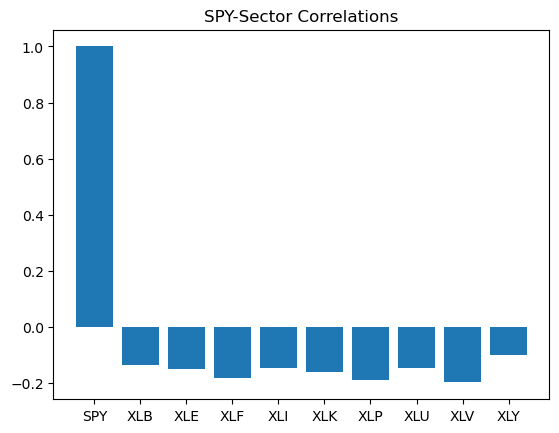

In [15]:
corr_matrix = in_sample_data.corr()
plt.bar(x=corr_matrix.index, height=corr_matrix["SPY"])
plt.title("SPY-Sector Correlations")

I see that there is not a lot of strong correlation between future SPY log returns and current sector log returns. This is is probably to be expected. It would be pretty amazing if they were very strongly correlated. We can attribute the slight negative correlations to mean reversion of the SPY at short horizons, i.e. tomorrow's SPY is unlikely to continue in the same direction.

Now let's go for the sector-sector correlations

In [16]:
corr_matrix.drop(["SPY"], axis=1).drop(["SPY"], axis=0)

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,,,,,,,,,
XLB,1.000000,0.699397,0.875193,0.912716,0.737162,0.711355,0.665550,0.744967,0.762540
XLE,0.699397,1.000000,0.734199,0.716695,0.456304,0.455016,0.435704,0.496836,0.488545
XLF,0.875193,0.734199,1.000000,0.913211,0.702552,0.697609,0.642547,0.728099,0.741475
XLI,0.912716,0.716695,0.913211,1.000000,0.742700,0.744066,0.695498,0.761514,0.780859
XLK,0.737162,0.456304,0.702552,0.742700,1.000000,0.671400,0.558601,0.749956,0.865889
XLP,0.711355,0.455016,0.697609,0.744066,0.671400,1.000000,0.787704,0.799236,0.630018
XLU,0.665550,0.435704,0.642547,0.695498,0.558601,0.787704,1.000000,0.724541,0.541294
XLV,0.744967,0.496836,0.728099,0.761514,0.749956,0.799236,0.724541,1.000000,0.677824
XLY,0.762540,0.488545,0.741475,0.780859,0.865889,0.630018,0.541294,0.677824,1.000000


I'm seeing a lot of positive correlation between the sector ETFs, and this is also to be expected because overarching macroeconomic factors will affect all sectors the same way. General economic health is the same for everyone. The pairwise plots below also reflect the same conclusion.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

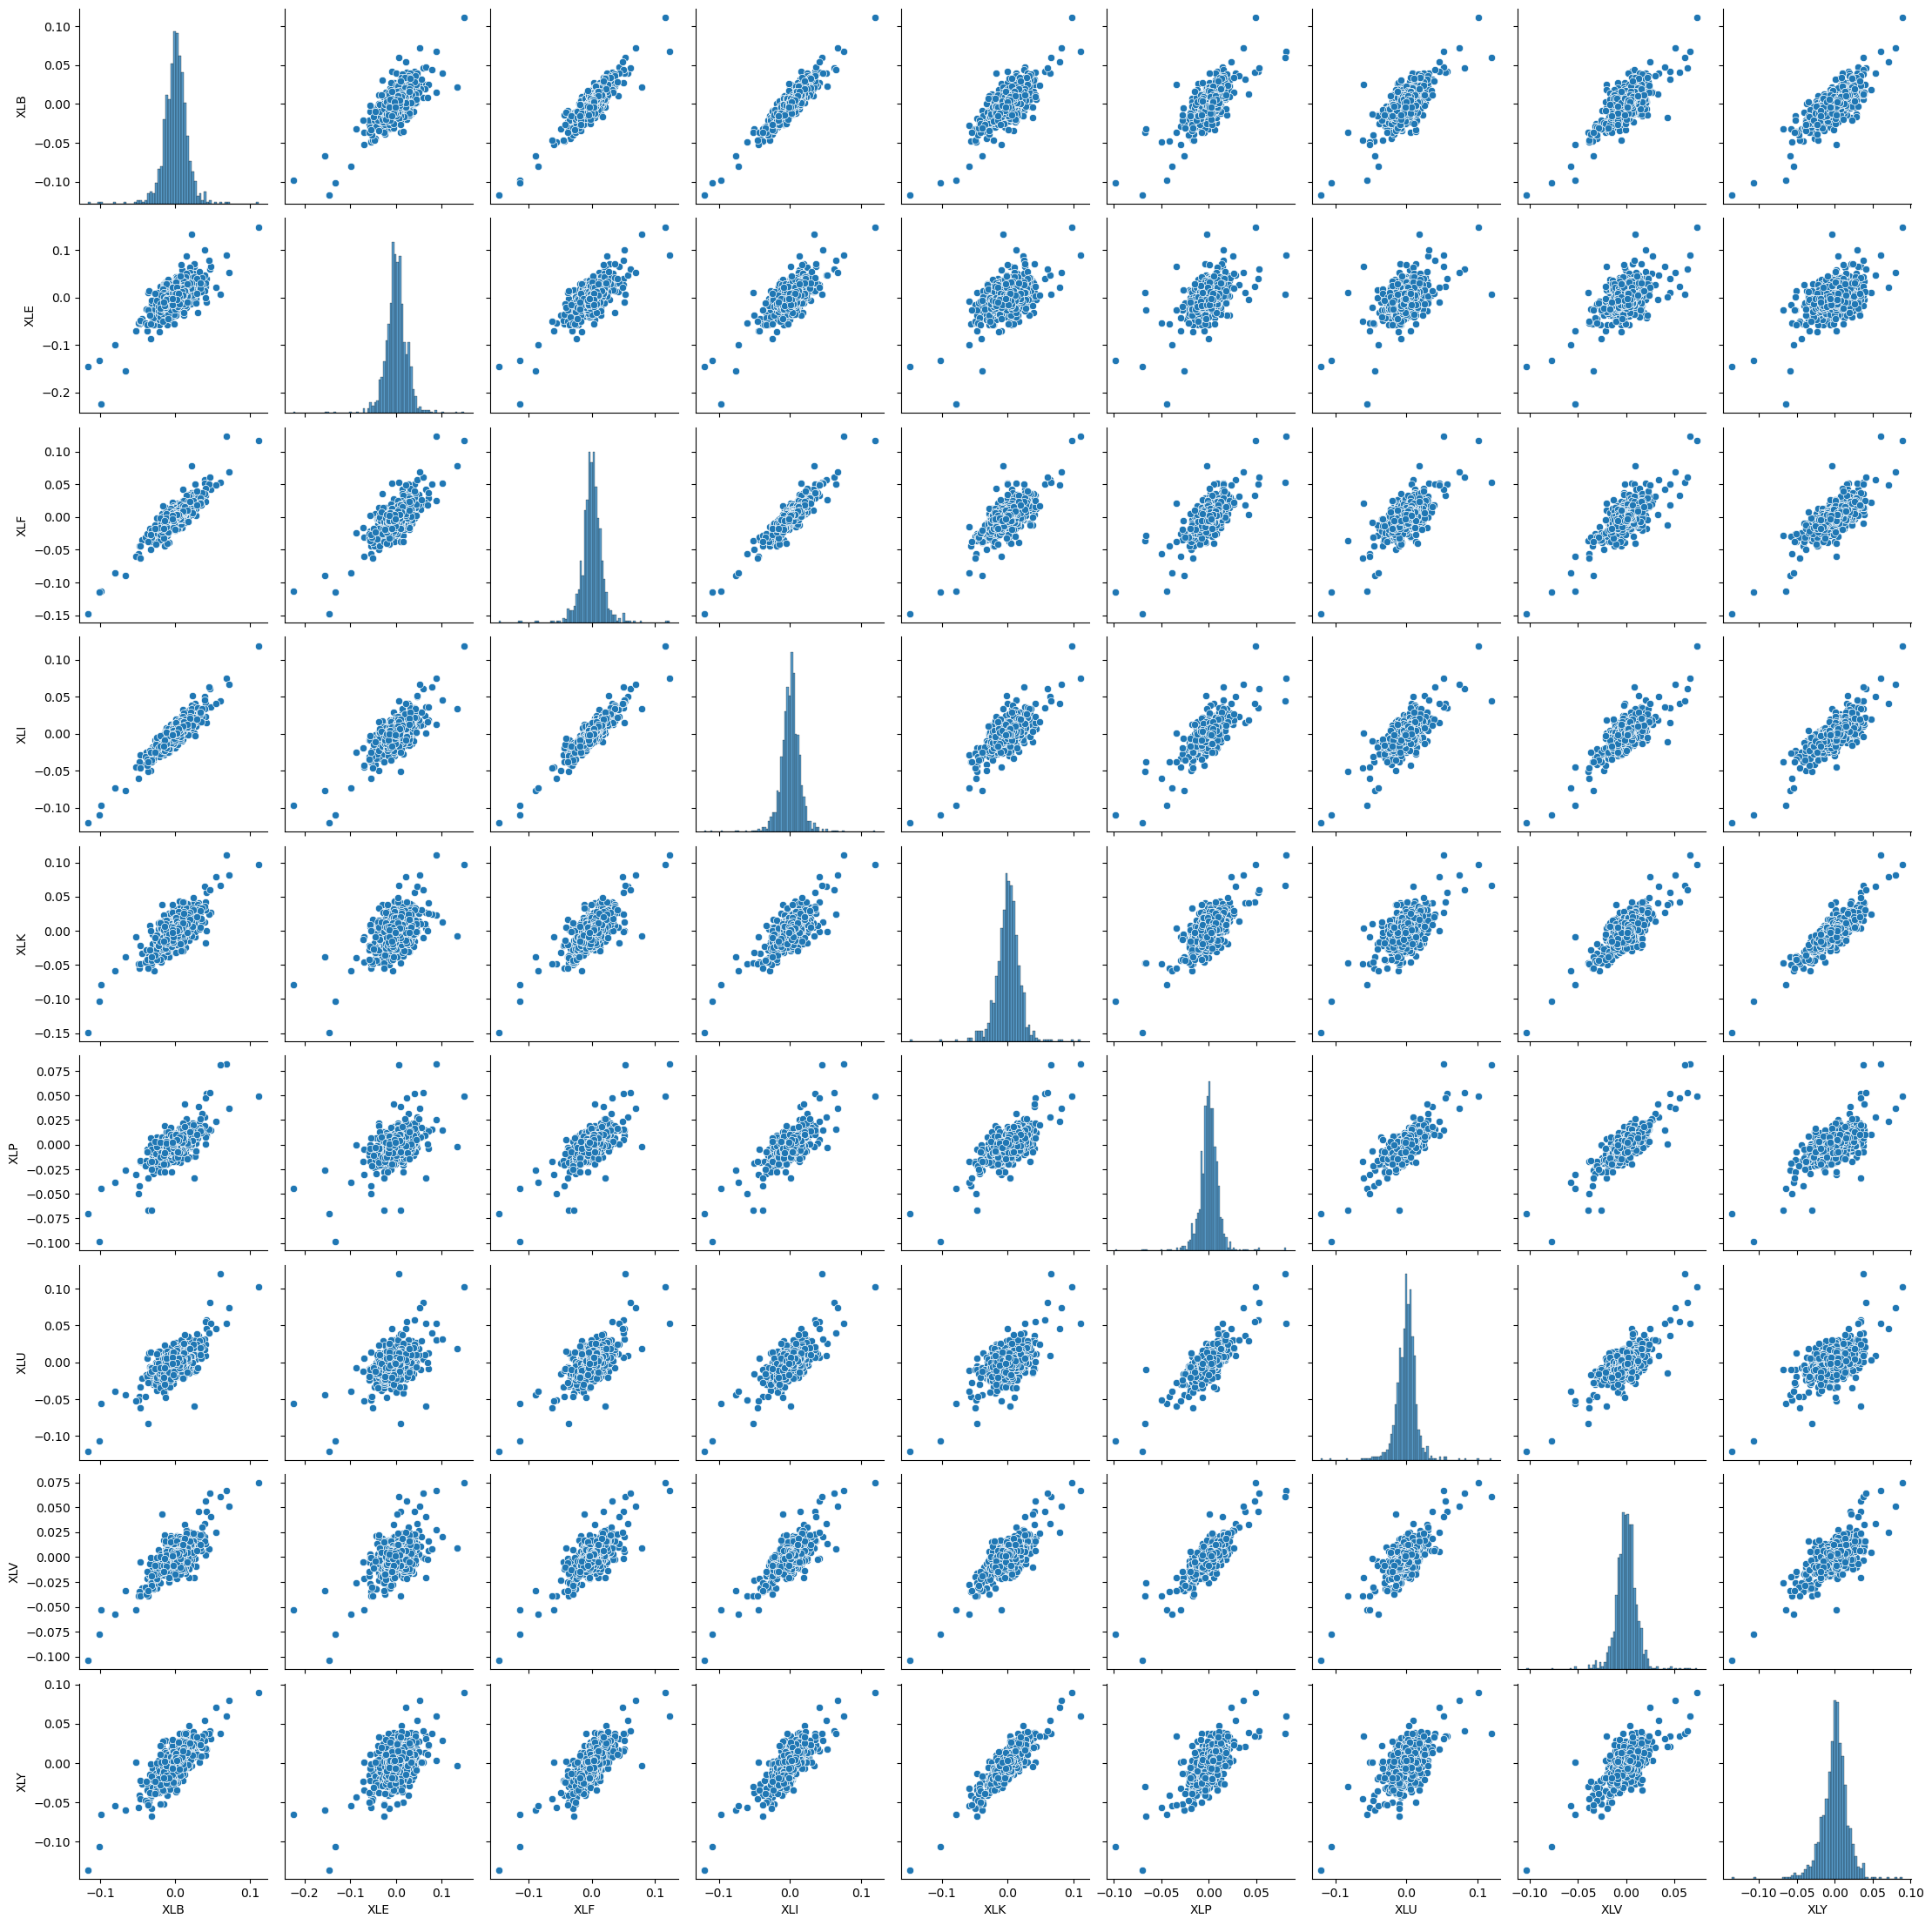

In [17]:
sns.pairplot(in_sample_data.drop(["SPY"], axis=1))

There are a lot of positively-sloping lines in this picture. This suggests that the log returns of the sector ETFs are highly correlated. 

<b>This suggests that we are going to have a multicollinearity problem on our hands (because our independent variables/regressors are highly correlated). This already tells us that we should probably use some form of regularized regression such as Ridge/Lasso/ElasticNet.</b>

#### (ii) Covariance Matrix

In [18]:
cov_mat = in_sample_data.cov()
cov_mat.drop(columns=["SPY"]).drop(["SPY"], axis=0)

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,,,,,,,,,
XLB,0.000268,0.000289,0.000259,0.000236,0.000223,0.000134,0.000171,0.000152,0.000218
XLE,0.000289,0.000637,0.000335,0.000286,0.000212,0.000132,0.000172,0.000156,0.000216
XLF,0.000259,0.000335,0.000327,0.000261,0.000234,0.000146,0.000182,0.000164,0.000235
XLI,0.000236,0.000286,0.000261,0.000250,0.000217,0.000136,0.000173,0.000150,0.000216
XLK,0.000223,0.000212,0.000234,0.000217,0.000340,0.000143,0.000162,0.000173,0.000279
XLP,0.000134,0.000132,0.000146,0.000136,0.000143,0.000133,0.000143,0.000115,0.000127
XLU,0.000171,0.000172,0.000182,0.000173,0.000162,0.000143,0.000246,0.000142,0.000148
XLV,0.000152,0.000156,0.000164,0.000150,0.000173,0.000115,0.000142,0.000156,0.000148
XLY,0.000218,0.000216,0.000235,0.000216,0.000279,0.000127,0.000148,0.000148,0.000306


In [19]:
print(f"The ETF with the largest volatility is {cov_mat.columns[np.argmax(np.diag(cov_mat))]} with variance {np.max(np.diag(cov_mat))}")

The ETF with the largest volatility is XLE with variance 0.0006366075514437359


This might not seem very revealing, but look at this

In [20]:
in_sample_data.mean() < in_sample_data.std() ** 2, in_sample_data.mean() < in_sample_data.std()

(0
 SPY    False
 XLB    False
 XLE     True
 XLF     True
 XLI    False
 XLK    False
 XLP    False
 XLU     True
 XLV    False
 XLY    False
 dtype: bool,
 0
 SPY    True
 XLB    True
 XLE    True
 XLF    True
 XLI    True
 XLK    True
 XLP    True
 XLU    True
 XLV    True
 XLY    True
 dtype: bool)

For each column of the data, the standard deviation (and variance mostly too) is greater than the mean. This tell us that our sector ETFs have high volatility. This is a statement about the individual ETFs and not their co-movements (which we know from the correlation matrix to be high as well). XLE appears to have the highest variance. Intuitively, this tells me that XLE is very volatile in and of itself, i.e. it moves a lot. But also, since it covaries a lot with other sectors, when it moves a lot, it moves the other sectors with it. This suggests that XLE will dominate the common factors the PCA will return.

The high volatility of the individual ETFs suggests that we should standardize our features using `StandardScaler` so that each of them has mean 0 and standard deviation 1. The reason this is done in Machine Learning is largely context-dependent. The most general reason is, of course, that we want to prevent the scale of our features (such as weight being expressed in grams instead of kilograms) from affecting our results. Some models are susceptible to this, while others aren't. We should definitely be using `StandardScaler` before employing any kind of regularization. The reasons differ here too-

* The point of Ridge regression is to shrink the coefficients slowly and together. If the features are on different scales, then the features with smaller variance will actually be shrunk unfairly more
* With Lasso, this effect is even more aggressive - the feature with smaller variance is more likely to be zeroed out

Finally, with PCA, standardizing is important based on the problem you want to solve. If we were to just apply PCA to the data without standardizing, it would return the component with the highest variance. Since we've observed that the individual ETFs have high and rather varying volatilities, the ETF with the highest volatility will dominate PC1. The rest of the PCs probably won't have that much explanatory power. This makes sense if what you want to find is the components of the raw data with the highest variance. 

However, we care about the regression. As we saw above, no particular ETF has a very strong correlation with the thing we want to predict. So our task is not to find the components in the raw data with the highest variance - it is to find the components with the highest shared variance among the original features. It might be possible that these PCs - which will explain the common factors between the original features - will have a higher correlation with the dependent variable. If this is the problem you wish to solve, you must standardize your features. For example, if we do so, it is very likely that our first PC will be the market factor, and this should have a decent amount of predictive power for the SPY

#### (iii) Rolling Correlations
It is often useful to observe how correlations between our regressors and dependent variables change over time.

First, we look at sector-SPY rolling correlations

In [21]:
window = 63
rolling_corr = (in_sample_data.rolling(window).corr(in_sample_data['SPY']))
rolling_corr

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1.0,0.052674,0.111983,0.105782,0.140494,0.067692,-0.015354,0.062357,0.094162,0.109045
2023-12-26,1.0,0.048895,0.110547,0.103035,0.138478,0.063626,-0.018465,0.057956,0.091574,0.106395
2023-12-27,1.0,0.050314,0.098433,0.106278,0.134099,0.065724,-0.010680,0.072095,0.097259,0.110684


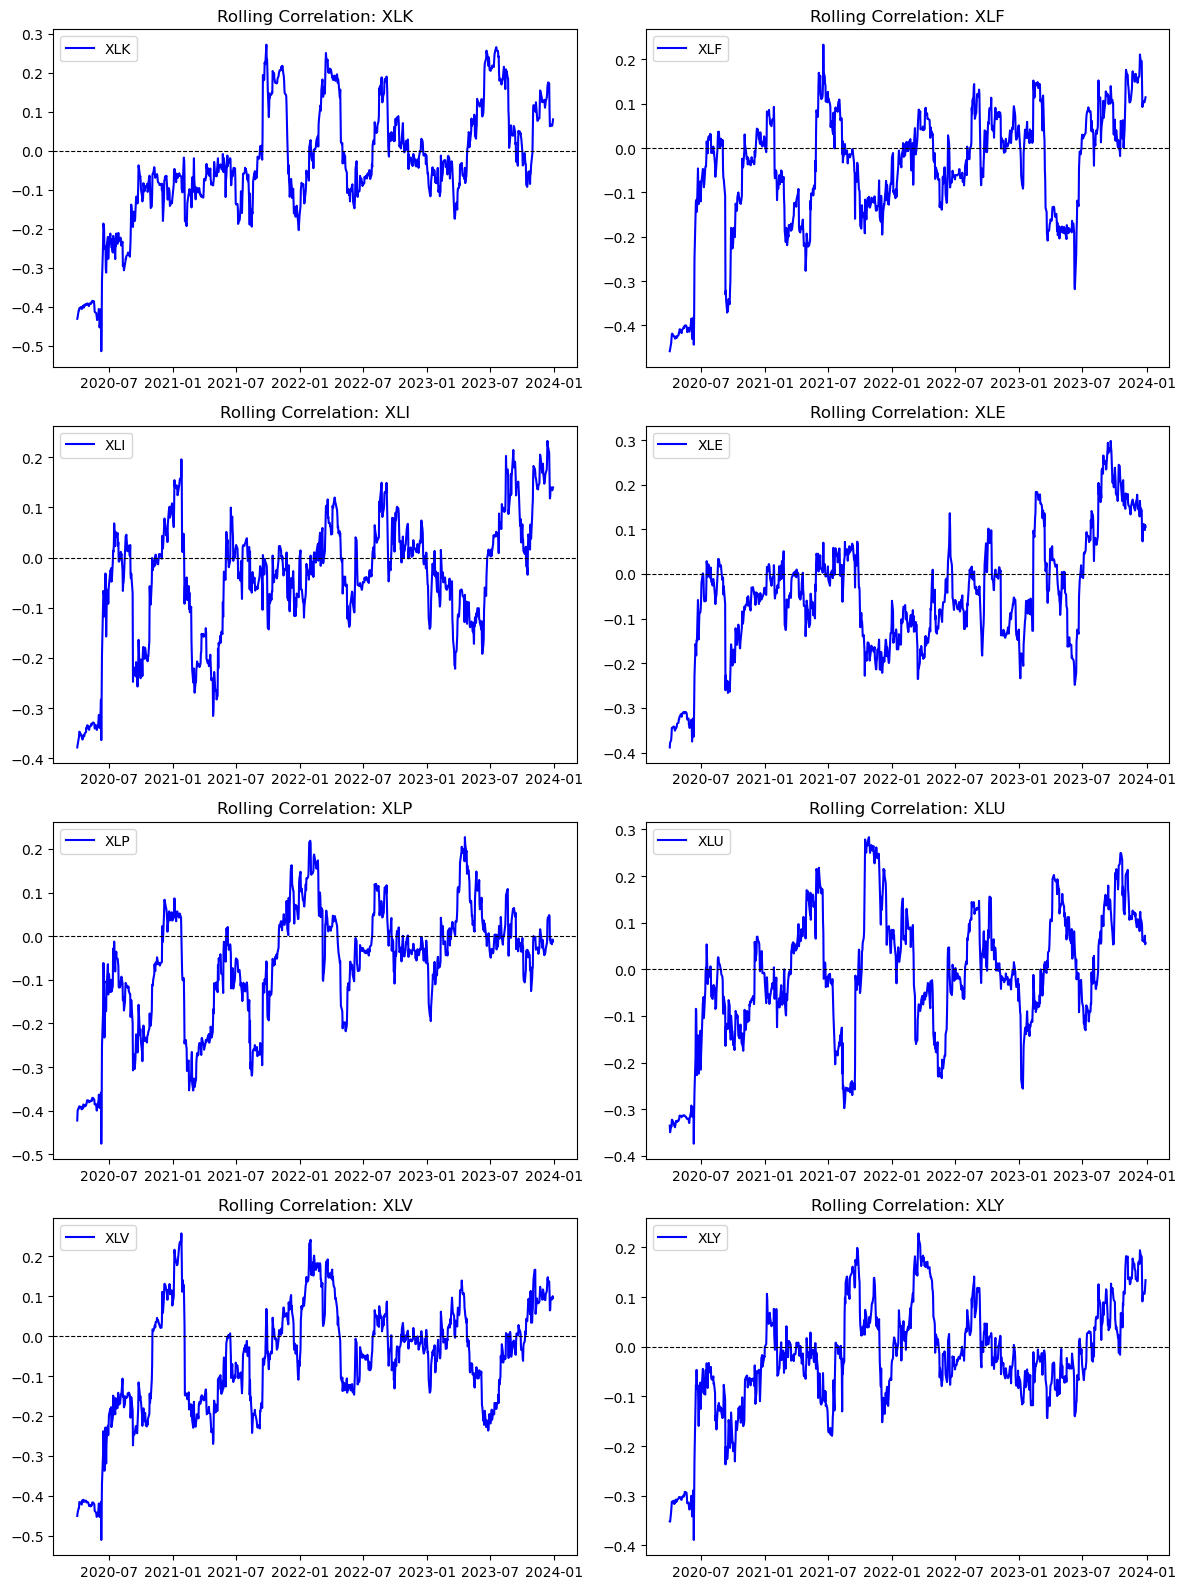

In [22]:
sectors = ['XLK', 'XLF', 'XLI', 'XLE', 'XLP', 'XLU', 'XLV', 'XLY']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), sharex=True)

axes = axes.flatten()

for i, sector in enumerate(sectors):
    ax = axes[i]
    ax.plot(rolling_corr[sector], label=sector, color='blue')
    ax.set_title(f'Rolling Correlation: {sector}')
    ax.tick_params(labelbottom=True)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Clearly, correlations between sectors and SPY are not constant over time. They are always changing, and there appears to be some sort of seasonality to it. This is strong evidence of regime-based behaviour. Also, we clearly cannot perform just one regression on the entire in-sample dataset and trust that value of beta. If the correlation evolves over time, then so must our regression coefficients. We must do something like a walk-forward workflow.

This might also suggest that we introduce some kind of regime-switching nature in our model. We could define a variable like $Z_t = \frac{1}{S}\sum_{s}\rho_{s, \text{SPY}}(t)$. Then,

* If $Z_t$ is high → market mode strong → use Ridge/PCA model
* If $Z_t$ is low → market fragmented → use sector-relative model

We could also fit two models:
| Regime           | Model                 |
| ---------------- | --------------------- |
| High correlation | PCA(1) + Ridge        |
| Low correlation  | Sector excess + Lasso |

Then, we could simply switch between the predictions of the two based on the rolling correlation.


Now let's go for sector-sector rolling correlations

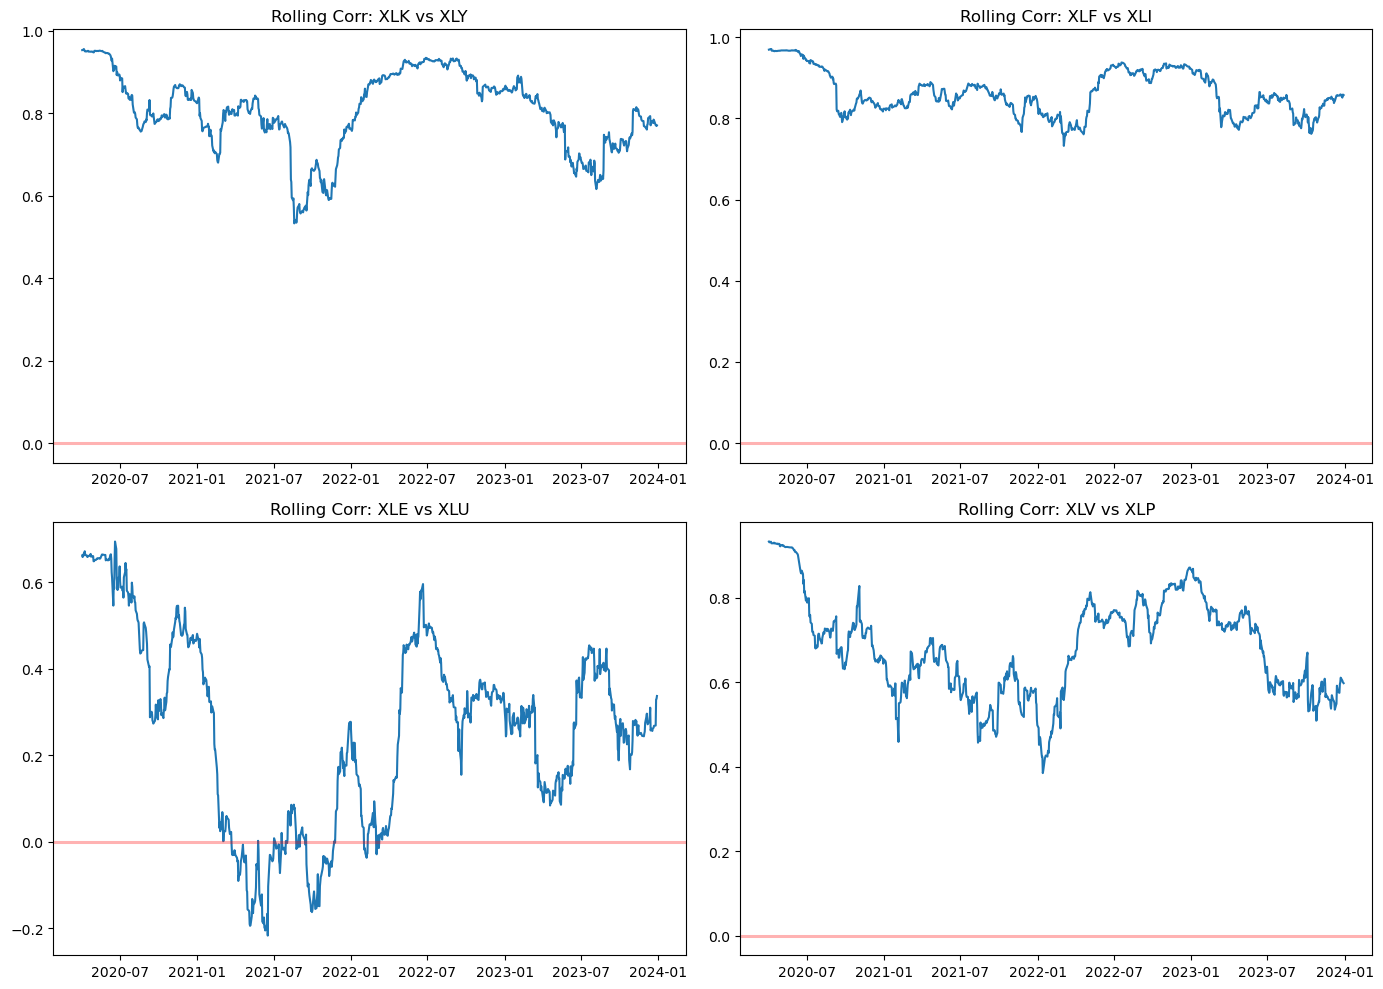

In [23]:
pairs = [('XLK', 'XLY'), ('XLF', 'XLI'), ('XLE', 'XLU'), ('XLV', 'XLP')]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, (s1, s2) in enumerate(pairs):
    rolling_val = in_sample_data[s1].rolling(window).corr(in_sample_data[s2])
    axes[i].plot(rolling_val)
    axes[i].set_title(f'Rolling Corr: {s1} vs {s2}')
    axes[i].axhline(0, color='red', alpha=0.3, linewidth=2.2)
    axes[i].tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

Here, we see some pretty interesting things:
* In the XLK-XLY correlation plot, we see that the correlation tends to stay pretty high in the 0.5 to 1 region. We could treat these as one factor maybe by using PCA to collapse the two into one. This could also be interpreted as stronger evidence for regularization in the form of Ridge/Lasso
* In the XLE-XLU correlation plot, we see that the correlation is highly varying, and that it even dips below 0 in 2021. This suggests that these two sectors, in the market regime of 2021, had reason to be negatively-correlated. Maybe we should include a variable like `spread = XLE - XLU`, or we should change strategies depending on when the correlation is negative vs. positive


#### (iv) Output of Structural Diagnostics

<b>From a Feature Engineering perspective</b>
* Given the high and varying volatilities of our sector ETFs, we should standardize our features using `StandardScaler` so that they are all on the same scale.

* Additionally, the high sector-sector correlations suggest that employing PCA could be a good option. This is because PCA (after standardizing the features) will find uncorrelated components along which the shared variance between the sector ETFs is maximized. Additionally, the new PCs could hopefully have higher correlations with the dependent variable than the current regressors.

<b>From a Statistical Modeling perspective</b>
* We are going to run into a multicollinearity problem because we observe high correlations between our current set of predictors. This suggests to us that we should include some kind of regularization in our regression such as Ridge or Lasso because OLS is going to be unstable.


* We observed that our correlations do change based on market regime. It would be of value to identify the various regimes that exist and use them tweak our model. Perhaps we use one model when one regime is in effect, and another when a different regime is in effect.

### b. In-Sample Excellence
We are now going to take the insights we've gained from the previous section and actually put them to use. We will use the in-sample data to determine which of Ridge, Lasso, ElasticNet, and OLS we should implement. We will also aim to tune the hyperparameters of these models and find out which is best.

#### (i) (Optional) Use Principal Components Analysis (PCA) to extract features
Using PCA to find the components along which the data varies the most is a very strong idea here

#### (ii) Statistical Learning
Now, we are getting to the Machine Learning part of the workflow. We want to evaluate the profitability of our strategies. To do this, we need to see how the strategies perform over time.

A strategy is a pairing of a model and a position sizing strategy. The latter takes the output of the ML model and converts it into a trading decision. After all, the ML model just outputs a number. We need to decide what that number means for us.

Since we want to tune hyperparameters, we will evaluate multiple Ridge/Lasso/ElasticNet models, each with different hyperparameters.

We will do walk-forward learning using an expanding window technique, which means that our ML models will be provided with incrementally-more information to base their predictions on. Inside each window, we will

* estimate our model
* generate prediction
* convert prediction to a position
* realize return
* expand window forward

It makes sense to use a moving window technique because as we saw with moving correlation plots above, the correlations between all entities change over time. This means that our model should also change over time. 

The output of this section should be a dictionary of Pandas DataFrames of the form `{model_name : output_details}`:
* The `model_name` is just the name of the model + position sizing strategy
* The `output_details` is a DataFrame consisting of a `datetime` index and model predictions (which will be the future SPY log return), actual future SPY log returns, leverage, and portfolio return as columns

#### Function to create Windows

In [24]:
def create_train_predict_calender(df, window_type, window_size):
    date_ranges = []
    index = df.index
    num_days = len(index)

    if window_type == 'fixed':
        # Rolling window: Use only recent window_size periods for training
        for i in range(window_size, num_days):
            train_start_date = index[i - window_size]
            train_end_date = index[i - 1]
            prediction_date = index[i]
            date_ranges.append([train_start_date, train_end_date, prediction_date])

    elif window_type == 'expanding':
        # Expanding window: Use all available historical data
        for i in range(window_size, num_days):
            train_start_date = index[0]
            train_end_date = index[i - 1]
            prediction_date = index[i]
            date_ranges.append([train_start_date, train_end_date, prediction_date])

    return date_ranges

#### Define Models

We first define the models that we are going to use to predict the future SPY returns. To make this as general as possible, we are going to use the sklearn `Pipeline` constructor, and so we specify models in the below format.

Note the use of `StandardScaler`.

In [25]:
models = []

def add_models(name, estimator, param_dict):
    keys = param_dict.keys()
    for values in product(*param_dict.values()):
        params = dict(zip(keys, values))
        label = "_".join(f"{k.split('__')[-1]}={v}" for k, v in params.items())

        models.append({
            'name': f"{name}_{label}",
            'pipe_steps': [
                ('scaler', StandardScaler()),
                ('model', estimator())
            ],
            'param_grid': params
        })

add_models(
    'ridge',
    Ridge,
    {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
)

add_models(
    'lasso',
    Lasso,
    {'model__alpha': [0.001, 0.01, 0.1]}
)

add_models(
    'elasticnet',
    ElasticNet,
    {
        'model__alpha': [0.01, 0.1],
        'model__l1_ratio': [0.2, 0.5, 0.8]
    }
)

models

[{'name': 'ridge_alpha=0.01',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Ridge())],
  'param_grid': {'model__alpha': 0.01}},
 {'name': 'ridge_alpha=0.1',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Ridge())],
  'param_grid': {'model__alpha': 0.1}},
 {'name': 'ridge_alpha=1.0',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Ridge())],
  'param_grid': {'model__alpha': 1.0}},
 {'name': 'ridge_alpha=10.0',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Ridge())],
  'param_grid': {'model__alpha': 10.0}},
 {'name': 'lasso_alpha=0.001',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Lasso())],
  'param_grid': {'model__alpha': 0.001}},
 {'name': 'lasso_alpha=0.01',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Lasso())],
  'param_grid': {'model__alpha': 0.01}},
 {'name': 'lasso_alpha=0.1',
  'pipe_steps': [('scaler', StandardScaler()), ('model', Lasso())],
  'param_grid': {'model__alpha': 0.1}},
 {'name': 'elasticnet_alpha=0.0

#### Define Position Sizing Strategies
Now, we define the position sizing functions:

* `calculate_binary_position` is an implementation of the Binary Position Sizer, which simply checks if the prediction of the future SPY log return is positive or negative. If the future log return, $l_{t+1} = \ln{\frac{P_{t+1}}{P_t}} = \ln{P_{t+1}}-\ln{P_t}$, is positive, this means that $P_{t+1} > P_t$ since $\ln$ is an increasing function

* `calculate_proportional_position` is an implementation of the Proportional Position Sizer. This is a magnitude-based position sizer with a `min_position` of 0 and `max_position` of 2. We will use the relative magnitude of our prediction to scale our position between 0 and 2. This is done by first scaling all predictions to numbers between 0 and 1 (via min-max normalization). If these normalized predictions are $\alpha$, then your position is $$(1-\alpha)*\text{Min Position} + \alpha*\text{Max Position}$$

With this position sizer, we only go long, and we believe that the relative size of our predictions matters and should reflect how confident we are. The question being asked here isn't "Should I go long or short?" It is rather "How bullish should I be?"

* `calculate_quartile_position` is an implementation if the Quartile Position Sizer. This is a ranking-based position sizer with a set of positions that are chosen from. One chooses a position from this set on the basis of the bucketing of their predictions - predictions are converted to z-scores by means of the `StandardScaler`, and are then fed as input into the CDF of the Normal Distribution (the $\Phi$ function). By doing this, we obtain the percentiles in the Normal Distribution each prediction corresponds to, and we then use these values to determine which percentile bracket each prediction falls into. On the basis of which bracket it resides in, a particular position is taken.

So the three position sizers take these three approaches respectively:
* Direction alone is enough (Binary)
* Magnitude matters (Proportional)
* General Ranking matters more than magnitude (Quartile)

To elucidate the difference between the three, let's consider a particular scenario in which each prediction in our `predictions` Series is negative. Then
* The Binary position sizer will go short for each time step
* The Proportional position sizer will go long each step, and it decides how long it wants to go on the basis of the magnitude of the predictions relative to each other (i.e. only the values in the Series matter).
* The Quartile position sizer will go long each step as well. But it decides how long it wants to go on the basis of its ranking as far as predictions go in general, i.e. its percentile in its probability distribution. It's not the ranking among the actual data points, but the ranking in the general probability distribution. So yes, this method assumes that the log returns are normally-distributed.

In [26]:
def calculate_binary_position(predictions, short_position=-1.0, long_position=1.0):
    conditions = [predictions <= 0, predictions > 0]
    positions = [short_position, long_position]
    return pd.Series(np.select(conditions, positions, default=np.nan), index=predictions.index)

def calculate_proportional_position(predictions, max_position=2.0, min_position=0.0):
    pred_min, pred_max = predictions.min(), predictions.max()
    if pred_max == pred_min:
        return pd.Series(min_position, index=predictions.index)
    
    normalized = (predictions - pred_min) / (pred_max - pred_min)
    positions = min_position + normalized * (max_position - min_position)
    
    return positions
    
def calculate_quartile_position(predictions, positions=[0, 0.5, 1.5, 2.0]):
    scaler = StandardScaler()
    normalized_preds = scaler.fit_transform(predictions.values.reshape(-1, 1)).flatten()
    quantile_preds = norm.cdf(normalized_preds)
    
    conditions = [
        (quantile_preds >= 0.00) & (quantile_preds < 0.25),
        (quantile_preds >= 0.25) & (quantile_preds < 0.50),
        (quantile_preds >= 0.50) & (quantile_preds < 0.75),
        (quantile_preds >= 0.75) & (quantile_preds <= 1.00)
    ]
    
    return pd.Series(np.select(conditions, positions, default=np.nan), index=predictions.index)

In [27]:
position_strategies = [
    {
        'name': 'Binary',
        'function': calculate_binary_position
    },
    {
        'name': 'Proportional',
        'function': calculate_proportional_position
    },
    {
        'name': 'Quartile',
        'function': calculate_quartile_position
    }
]

#### Run Models

In [28]:
X = in_sample_data[sectors]
y = in_sample_data["SPY"]

In [29]:
date_ranges = create_train_predict_calender(df=X, window_type='expanding', window_size=200)

In [30]:
portfolio_output = {}
ml_output = {}

for model_config in models:
    for sizer_config in position_strategies:

        strat_tag = f"{model_config['name']}_{sizer_config['name']}"
        strat_df = pd.DataFrame(index=y.index)
        
        for n, dates in enumerate(date_ranges):
            #create X and y
            start_train, end_train, pred_date = dates[0], dates[1], dates[2]
            fit_X, fit_y, pred_X = X[start_train : end_train], y[start_train : end_train], X[pred_date : pred_date]

            if n % 252 == 0:
                print(f"  ... processing date {pred_date.date()} ({n}/{len(date_ranges)})")
            
            # fit model
            fit_obj = Pipeline(steps=model_config['pipe_steps']).set_output(transform='pandas')
            fit_obj.set_params(**model_config['param_grid'])
            fit_obj.fit(fit_X, fit_y)
            m = fit_obj.named_steps["model"]

            # obtain predictions
            prediction = fit_obj.predict(pred_X)
            strat_df.loc[pred_date, 'Predicted Return'] = prediction
            strat_df.loc[pred_date, 'Coefficient'] = np.linalg.norm(m.coef_)
            
        # feed to sizer function and obtain portfolio leverage
        strat_df['Actual Returns'] = y.loc[strat_df.index]
        strat_df['Leverage'] = sizer_config['function'](strat_df['Predicted Return'])
        # strat_df['Portfolio Returns'] = strat_df['Leverage'] * np.exp(strat_df['Actual Returns']) # this line is an approximation
        strat_df['Portfolio Returns'] = strat_df['Leverage'] * strat_df['Actual Returns']

        # store dataframe in final output dictionary
        portfolio_output[strat_tag] = strat_df.dropna()
        ml_output[model_config['name']] = strat_df.dropna()[["Predicted Return", "Actual Returns"]]

        print(f"\nFinished running {strat_tag}\n")

  ... processing date 2020-10-19 (0/805)
  ... processing date 2021-10-19 (252/805)
  ... processing date 2022-10-19 (504/805)
  ... processing date 2023-10-20 (756/805)

Finished running ridge_alpha=0.01_Binary

  ... processing date 2020-10-19 (0/805)
  ... processing date 2021-10-19 (252/805)
  ... processing date 2022-10-19 (504/805)
  ... processing date 2023-10-20 (756/805)

Finished running ridge_alpha=0.01_Proportional

  ... processing date 2020-10-19 (0/805)
  ... processing date 2021-10-19 (252/805)
  ... processing date 2022-10-19 (504/805)
  ... processing date 2023-10-20 (756/805)

Finished running ridge_alpha=0.01_Quartile

  ... processing date 2020-10-19 (0/805)
  ... processing date 2021-10-19 (252/805)
  ... processing date 2022-10-19 (504/805)
  ... processing date 2023-10-20 (756/805)

Finished running ridge_alpha=0.1_Binary

  ... processing date 2020-10-19 (0/805)
  ... processing date 2021-10-19 (252/805)
  ... processing date 2022-10-19 (504/805)
  ... processi

In [31]:
%%capture
portfolio_output

In [32]:
%%capture
ml_output

Our strategies have finished training. We are now ready to evaluate them based on these results.

#### Evaluate Strategy Profitability by Calculating Statistics and Metrics
We want to know the annualized return, total return, volatility, Sharpe Ratio, Max Drawdown, Calmar Ratio, Skewness and Kurtosis of the strategies.

##### $\text{Total Return} = e^{\sum r_i} - 1$
Total Return is the percentage return achieved on $\$1$ invested at the beginning of time. It's calculated here by summing all the log returns $r_i$. This gives us $\log{\frac{P_T}{P_0}}$. We then exponentiate this to remove the $\log$ and obtain $\frac{P_T}{P_0}$. This is the multiplier associated with the percentage increase in the Finally, we subtract 1 to obtain the percentage return. 

##### $\text{Annualized Return} = e^{252\bar{r}} - 1$
Annualized return is the constant yearly growth rate that would give you the same average log-return as your strategy actually produced. More intuitively, it's a measure of the average annual return. It's calculated by taking the average return obtained across all time steps and multiplying by 252. This is done to obtain an estimate of the expected annual log return under the assumption of stationarity ($E[\sum_{i=1}^{252}r_i] = 252 E[r_i]$ when the returns are stationary). This is then exponentiated, and then 1 is subtracted to obtain the percentage return

##### $\text{Volatility (Annual)} = \text{std(returns)}\sqrt{252}$
Volatility is a measure of the annual risk of a strategy under the assumption of stationarity of returns. We take the daily standard deviation of the returns Series and multiply by $\sqrt{252}$ to convert it to an annual standard deviation.

##### $\text{Sharpe Ratio (Annual)} = \frac{252\bar{r}}{volatility}$
The Sharpe Ratio is a measure of risk-adjusted annual returns. It is theoretically expressed as $\frac{E[r] - r_f}{\sigma}$, i.e. the excess return of the strategy divided by the standard deviation. So, in some sense, we are measuring how much excess return we are getting per unit of risk. In order to convert a daily Sharpe Ratio into an annual Sharpe Ratio, we multiply by $\sqrt{252}$ (given the way we calculate volatility in the code, we just multiply by 252).

##### $\text{Max Drawdown}$
To understand the max drawdown calculation, we should first understand what a drawdown is. A drawdown at time $t$ is a measure of how much your realized wealth is below the peak wealth achieved in the time from 0 to $t$. So in that time, we might have achieved some peak wealth $W_{\text{max}, t}$, but at time $t$, our wealth might have dropped from that peak. Then $\text{drawdown}_t = \frac{W_t - W_{\text{max}, t}}{W_{\text{max}, t}}$

This number is always non-positive, and of course, the larger this number (in absolute value, which is also what we calculate here), the worse the strategy appears.

##### $\text{Sortino Ratio} = \frac{E[r-r_f]}{\sigma_{\text{down}}}$
The Sortino Ratio is a variation of the Sharpe Ratio that penalizes only downside risk, rather than total volatility. While the Sharpe Ratio treats positive and negative deviations from the mean symmetrically, the Sortino Ratio recognizes that upside volatility is generally desirable and should not be treated as risk. Instead of dividing excess return by the total standard deviation of returns, the Sortino Ratio divides excess return by the downside deviation, defined as the standard deviation of returns that fall below a target threshold (typically zero or the risk-free rate). Intuitively, the Sortino Ratio measures how much excess return the strategy delivers per unit of bad volatility.

##### $\text{Calmar Ratio} = \frac{\text{Annualized Return}}{|\text{Max Drawdown}|}$
The Calmar Ratio measures return relative to maximum realized downside risk, rather than volatility-based risk. It is defined as the ratio of the annualized return to the absolute value of the maximum drawdown. Intuitively, the Calmar Ratio answers the question "How much annual growth did this strategy achieve per unit of worst-case historical loss?" Unlike volatility-based metrics, the Calmar Ratio is explicitly path-dependent, since maximum drawdown depends on the ordering of returns over time. As a result, it captures risk that volatility and Sharpe-style measures can completely miss — particularly the severity of sustained losses. The Calmar Ratio is especially popular for evaluating trend-following strategies, leveraged strategies, and strategies with fat tails or serial dependence because it directly reflects the worst pain experienced by the investor.

##### $\text{Skewness}$
Skewness measures the asymmetry of the distribution of log returns. It indicates whether large positive and negative returns occur with equal frequency and magnitude, or whether the distribution is tilted toward one side. Positive skewness indicates a return distribution with a longer or heavier right tail, meaning large positive returns occur more frequently than large negative returns. Negative skewness indicates a distribution with a longer or heavier left tail, meaning extreme losses occur more frequently than extreme gains. In the context of trading strategies, skewness is an important descriptive statistic because it captures asymmetric tail risk that is not reflected in mean or volatility. Two strategies may have similar average returns and volatility but very different skewness, leading to different risk profiles and investor experiences.

##### $\text{Kurtosis}$
Kurtosis measures the tailedness of the distribution of log returns, describing how frequently extreme outcomes occur relative to a reference distribution. High kurtosis indicates fat tails, meaning large positive or negative returns occur more frequently. Low kurtosis indicates thinner tails and fewer extreme observations. In financial return series, high kurtosis is commonly observed and reflects the presence of tail risk — rare but significant events that are not well captured by variance-based measures such as volatility.

In [33]:
def calculate_portfolio_metrics(returns):
    '''
    Returns several measures of the performance of the trading strategy
    Takes portfolio returns as input
    '''
    annualized_return = np.exp(returns.mean() * 252) - 1
    volatility = returns.std() * np.sqrt(252)
    
    cumulative = np.exp(returns.cumsum())
    running_max = cumulative.expanding().max()
    drawdown = (running_max - cumulative) / running_max
    max_drawdown = drawdown.max()

    wins = (returns > 0).sum()
    losses = (returns < 0).sum()
    total_trades = wins + losses    
    
    return {
        "Total Return" : np.exp(returns.sum()) - 1,
        "Annualized Return" : annualized_return,
        "Volatility (Annual)" : volatility,
        "Sharpe Ratio (Annual)" : 252 * returns.mean() / volatility,
        "Max Drawdown" : max_drawdown,
        "Sortino Ratio" : emp.sortino_ratio(np.exp(returns) - 1),
        "Calmar Ratio" : annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0,
        "Win Rate" : wins / total_trades if total_trades > 0 else np.nan,
        "Skewness" : skew(returns),
        "Kurtosis" : kurtosis(returns)
    }

def calculate_model_metrics(model_predictions, actual):
    '''
    Returns several measures of the performance of the regression model itself
    Takes model predictions and actual values as input
    '''

    rms_error = rmse(model_predictions, actual)
    return {
        "RMSE" : rms_error,
        "%RMSE" : rms_error / actual.mean(),
        "MAE" : mae(model_predictions, actual),
        r"$R^2$" : r2_score(actual, model_predictions)
    }

def strategy_performance(strat_output, ml_output):
    portfolio_df = pd.DataFrame()
    portfolio_df.index.name = "Metrics"

    ml_df = pd.DataFrame()
    ml_df.index.name = "Metrics"

    for strat_tag, strat_performance in strat_output.items():
        portfolio_metrics = pd.Series(calculate_portfolio_metrics(strat_performance["Portfolio Returns"]))
        portfolio_metrics["Model Type"] = strat_tag.split('_')[0]
        portfolio_metrics["Position Sizer Type"] = strat_tag.split('_')[-1]
        portfolio_df[strat_tag] = portfolio_metrics
        
    for model, model_performance in ml_output.items():
        model_metrics = pd.Series(calculate_model_metrics(model_performance["Predicted Return"], model_performance["Actual Returns"]))
        ml_df[model] = model_metrics
        
    return portfolio_df, ml_df

portfolio_eval, ml_eval = strategy_performance(portfolio_output, ml_output)

I want to sort these results by Sortino Ratio

In [34]:
portfolio_eval.T.sort_values(by="Sortino Ratio")

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type
ridge_alpha=10.0_Binary,-0.015024,-0.004728,0.17504,-0.027074,0.239543,0.087126,-0.019737,0.505604,0.133989,1.625232,ridge,Binary
ridge_alpha=0.01_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,ridge,Binary
ridge_alpha=0.1_Binary,0.026059,0.008086,0.17504,0.046007,0.233931,0.19376,0.034564,0.501868,0.14336,1.622672,ridge,Binary
ridge_alpha=1.0_Binary,0.070307,0.021498,0.175035,0.121517,0.233931,0.304817,0.091898,0.503113,0.14656,1.620008,ridge,Binary
elasticnet_alpha=0.1_l1_ratio=0.5_Quartile,0.086536,0.026321,0.188414,0.137893,0.377577,0.314069,0.069711,0.535294,-0.76683,4.279076,elasticnet,Quartile
elasticnet_alpha=0.1_l1_ratio=0.2_Quartile,0.086536,0.026321,0.188414,0.137893,0.377577,0.314069,0.069711,0.535294,-0.76683,4.279076,elasticnet,Quartile
lasso_alpha=0.1_Quartile,0.086536,0.026321,0.188414,0.137893,0.377577,0.314069,0.069711,0.535294,-0.76683,4.279076,lasso,Quartile
lasso_alpha=0.01_Quartile,0.086536,0.026321,0.188414,0.137893,0.377577,0.314069,0.069711,0.535294,-0.76683,4.279076,lasso,Quartile
elasticnet_alpha=0.1_l1_ratio=0.8_Quartile,0.086536,0.026321,0.188414,0.137893,0.377577,0.314069,0.069711,0.535294,-0.76683,4.279076,elasticnet,Quartile
elasticnet_alpha=0.01_l1_ratio=0.8_Quartile,0.130397,0.039115,0.188295,0.203772,0.367032,0.403781,0.106571,0.540275,-0.778458,4.308996,elasticnet,Quartile


There are a few things I see here. 

* I see that there some rows in this table with duplicate values. For example, the strategies `elasticnet_alpha=0.1_l1_ratio=0.2_Binary` and `lasso_alpha=0.01_Binary` both have exactly the same values in their respective rows. This is uncanny because these are two different ML models with different hyperparameters producing exactly the same results
* I see that from a Sortino Ratio perspective, the `ridge_alpha=0.1_Proportional` and `ridge_alpha=0.01_Proportional` strategies performed the best.

To debug the first oddity, I went back to the model fitting section above and included a line of code that stores the coefficients settled upon by the regression. Let's see what coefficients have been discovered by the model

In [35]:
%%capture
portfolio_output["elasticnet_alpha=0.1_l1_ratio=0.2_Binary"]["Coefficient"]

In [36]:
%%capture
portfolio_output["lasso_alpha=0.01_Binary"]["Coefficient"]

We can see here that the coefficients found are all 0. What's happening is that because we've set the value of $\alpha$ too high (i.e. we've made the regularization too stringent), the best the model can do is setting all the $\beta$ coefficients besides the intercept $\beta_0$ to 0. We need to lower the value of $\alpha$ and try again

In [37]:
%%capture
models = []
portfolio_output = {}
ml_output = {}

def add_models(name, estimator, param_dict):
    keys = param_dict.keys()
    for values in product(*param_dict.values()):
        params = dict(zip(keys, values))
        label = "_".join(f"{k.split('__')[-1]}={v}" for k, v in params.items())

        models.append({
            'name': f"{name}_{label}",
            'pipe_steps': [
                ('scaler', StandardScaler()),
                ('model', estimator())
            ],
            'param_grid': params
        })

add_models(
    'ridge',
    Ridge,
    {'model__alpha': [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]}
)

add_models(
    'lasso',
    Lasso,
    {'model__alpha': [1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]}
)

add_models(
    'elasticnet',
    ElasticNet,
    {
        'model__alpha': [1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
        'model__l1_ratio': [0.2, 0.5, 0.8]
    }
)

for model_config in models:
    for sizer_config in position_strategies:

        strat_tag = f"{model_config['name']}_{sizer_config['name']}"
        strat_df = pd.DataFrame(index=y.index)
        
        for n, dates in enumerate(date_ranges):
            #create X and y
            start_train, end_train, pred_date = dates[0], dates[1], dates[2]
            fit_X, fit_y, pred_X = X[start_train : end_train], y[start_train : end_train], X[pred_date : pred_date]

            if n % 252 == 0:
                print(f"  ... processing date {pred_date.date()} ({n}/{len(date_ranges)})")
            
            # fit model
            fit_obj = Pipeline(steps=model_config['pipe_steps']).set_output(transform='pandas')
            fit_obj.set_params(**model_config['param_grid'])
            fit_obj.fit(fit_X, fit_y)
            m = fit_obj.named_steps["model"]

            # obtain predictions
            prediction = fit_obj.predict(pred_X)
            strat_df.loc[pred_date, 'Predicted Return'] = prediction
            strat_df.loc[pred_date, 'Coefficient'] = np.linalg.norm(m.coef_)
            
        # feed to sizer function and obtain portfolio leverage
        strat_df['Actual Returns'] = y.loc[strat_df.index]
        strat_df['Leverage'] = sizer_config['function'](strat_df['Predicted Return'])
        # strat_df['Portfolio Returns'] = strat_df['Leverage'] * np.exp(strat_df['Actual Returns']) # this line is an approximation
        strat_df['Portfolio Returns'] = strat_df['Leverage'] * strat_df['Actual Returns']

        # store dataframe in final output dictionary
        portfolio_output[strat_tag] = strat_df.dropna()
        ml_output[model_config['name']] = strat_df.dropna()[["Predicted Return", "Actual Returns"]]

        print(f"\nFinished running {strat_tag}\n")

portfolio_eval, ml_eval = strategy_performance(portfolio_output, ml_output)

In [38]:
portfolio_eval.T.sort_values(by="Sortino Ratio")

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type
elasticnet_alpha=0.001_l1_ratio=0.2_Binary,-0.083761,-0.027013,0.175032,-0.156454,0.21461,-0.101012,-0.12587,0.488169,0.303982,1.636615,elasticnet,Binary
elasticnet_alpha=0.0003_l1_ratio=0.5_Binary,-0.051164,-0.016306,0.175037,-0.093927,0.213578,-0.009405,-0.076349,0.493151,0.279886,1.63105,elasticnet,Binary
elasticnet_alpha=0.0001_l1_ratio=0.5_Binary,-0.015271,-0.004806,0.17504,-0.027521,0.221839,0.086866,-0.021663,0.499377,0.155913,1.625399,elasticnet,Binary
lasso_alpha=0.0001_Binary,0.016626,0.005175,0.17504,0.02949,0.200099,0.171967,0.025864,0.496887,0.265199,1.622347,lasso,Binary
elasticnet_alpha=0.0003_l1_ratio=0.2_Binary,0.01851,0.005758,0.17504,0.032801,0.216759,0.174958,0.026564,0.498132,0.157075,1.623022,elasticnet,Binary
ridge_alpha=1e-06_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,ridge,Binary
lasso_alpha=1e-07_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,lasso,Binary
elasticnet_alpha=3e-06_l1_ratio=0.8_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,elasticnet,Binary
elasticnet_alpha=3e-06_l1_ratio=0.5_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,elasticnet,Binary
lasso_alpha=3e-07_Binary,0.020368,0.006332,0.17504,0.03606,0.233931,0.179306,0.027068,0.500623,0.145201,1.623004,lasso,Binary


In [39]:
portfolio_output["ridge_alpha=1e-06_Proportional"]["Coefficient"].iloc[0], portfolio_output["ridge_alpha=3e-06_Proportional"]["Coefficient"].iloc[0]

(0.02716509664253934, 0.027165092508284076)

Here, while it appears we have the same problem, a deeper look reveals that the two coefficients are not exactly the same. The reason is now the opposite of what it was before - the $\alpha$ values are so small that changing them doesn't make much of a difference. As we can see above, the predictions are only very slightly different.

In [40]:
ml_eval

,ridge_alpha=1e-06,ridge_alpha=3e-06,ridge_alpha=1e-05,ridge_alpha=3e-05,ridge_alpha=0.0001,ridge_alpha=0.0003,ridge_alpha=0.001,ridge_alpha=0.003,ridge_alpha=0.01,lasso_alpha=1e-07,lasso_alpha=3e-07,lasso_alpha=1e-06,lasso_alpha=3e-06,lasso_alpha=1e-05,lasso_alpha=3e-05,lasso_alpha=0.0001,lasso_alpha=0.0003,lasso_alpha=0.001,elasticnet_alpha=1e-07_l1_ratio=0.2,elasticnet_alpha=1e-07_l1_ratio=0.5,elasticnet_alpha=1e-07_l1_ratio=0.8,elasticnet_alpha=3e-07_l1_ratio=0.2,elasticnet_alpha=3e-07_l1_ratio=0.5,elasticnet_alpha=3e-07_l1_ratio=0.8,elasticnet_alpha=1e-06_l1_ratio=0.2,elasticnet_alpha=1e-06_l1_ratio=0.5,elasticnet_alpha=1e-06_l1_ratio=0.8,elasticnet_alpha=3e-06_l1_ratio=0.2,elasticnet_alpha=3e-06_l1_ratio=0.5,elasticnet_alpha=3e-06_l1_ratio=0.8,elasticnet_alpha=1e-05_l1_ratio=0.2,elasticnet_alpha=1e-05_l1_ratio=0.5,elasticnet_alpha=1e-05_l1_ratio=0.8,elasticnet_alpha=3e-05_l1_ratio=0.2,elasticnet_alpha=3e-05_l1_ratio=0.5,elasticnet_alpha=3e-05_l1_ratio=0.8,elasticnet_alpha=0.0001_l1_ratio=0.2,elasticnet_alpha=0.0001_l1_ratio=0.5,elasticnet_alpha=0.0001_l1_ratio=0.8,elasticnet_alpha=0.0003_l1_ratio=0.2,elasticnet_alpha=0.0003_l1_ratio=0.5,elasticnet_alpha=0.0003_l1_ratio=0.8,elasticnet_alpha=0.001_l1_ratio=0.2,elasticnet_alpha=0.001_l1_ratio=0.5,elasticnet_alpha=0.001_l1_ratio=0.8
Metrics,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RMSE,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000135,0.000133,0.000129,0.000126,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000135,0.000135,0.000135,0.000134,0.000133,0.000134,0.000132,0.000130,0.000131,0.000128,0.000127
%RMSE,0.293838,0.293838,0.293838,0.293838,0.293838,0.293838,0.293837,0.293834,0.293825,0.293831,0.293816,0.293765,0.293618,0.293115,0.291732,0.287309,0.279080,0.273140,0.293837,0.293835,0.293833,0.293834,0.293827,0.293821,0.293823,0.293801,0.293779,0.293793,0.293727,0.293662,0.293688,0.293471,0.293257,0.293390,0.292757,0.292137,0.292380,0.290385,0.288494,0.289662,0.284646,0.280984,0.282300,0.275813,0.274289
MAE,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008818,0.008816,0.008809,0.008789,0.008721,0.008555,0.008374,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008819,0.008818,0.008819,0.008818,0.008817,0.008817,0.008814,0.008811,0.008813,0.008804,0.008795,0.008798,0.008769,0.008740,0.008758,0.008673,0.008599,0.008626,0.008469,0.008405
$R^2$,-0.120735,-0.120735,-0.120735,-0.120735,-0.120734,-0.120733,-0.120730,-0.120719,-0.120682,-0.120707,-0.120651,-0.120454,-0.119896,-0.117978,-0.112703,-0.095830,-0.064446,-0.041790,-0.120729,-0.120721,-0.120713,-0.120718,-0.120693,-0.120668,-0.120677,-0.120594,-0.120510,-0.120562,-0.120312,-0.120061,-0.120160,-0.119335,-0.118517,-0.119026,-0.116609,-0.114248,-0.115174,-0.107565,-0.100351,-0.104806,-0.085674,-0.071708,-0.076725,-0.051983,-0.046171


#### Results of In-Sample Excellence
The goal of the in-sample excellence step is to freeze the model class, hyperparameters, position sizer, and feature engineering choices. The methodology we follow to do this is simple:

$\boxed{\text{Trading metrics dominate. Prediction metrics are only tie-breakers}}$

We do this because we don't get paid for low RMSE - we get paid for robust risk-adjusted returns

Let's first filter strategies by economic viability. I'll define such strategies to have
* a Sharpe Ratio of at least 0.5
* a max drawdown of below 0.3

In [41]:
cond = (portfolio_eval.T['Sharpe Ratio (Annual)'] > 0.5) & (portfolio_eval.T['Max Drawdown'] < 0.3)
econ_viable = portfolio_eval.T[cond]
econ_viable

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type
ridge_alpha=1e-06_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=3e-06_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=1e-05_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=3e-05_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=0.0001_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=0.0003_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=0.001_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=0.003_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
ridge_alpha=0.01_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,ridge,Quartile
lasso_alpha=1e-07_Quartile,0.535637,0.143711,0.226307,0.593348,0.29982,1.05716,0.479326,0.524922,0.187965,7.654618,lasso,Quartile


Now, let's prefer strategies with stability (since we want stable returns). You could do this by studying the rolling Sharpe Ratio plots of these strategies. For now, my metric is much simpler - I will look for the strategies with lower drawdowns. If drawdowns are large, this would mean that the strategy experienced a major dip from the maximum return so far, and is therefore unstable.

In [42]:
econ_viable_sorted = econ_viable.sort_values(by="Max Drawdown").head()
econ_viable_sorted

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type
elasticnet_alpha=3e-05_l1_ratio=0.5_Quartile,0.549142,0.146851,0.223665,0.61261,0.26802,1.094344,0.547909,0.524845,0.28987,7.690716,elasticnet,Quartile
elasticnet_alpha=0.0001_l1_ratio=0.2_Quartile,0.568994,0.151431,0.223192,0.631767,0.2694,1.126058,0.562106,0.525581,0.306409,7.718919,elasticnet,Quartile
elasticnet_alpha=3e-05_l1_ratio=0.8_Quartile,0.568994,0.151431,0.223192,0.631767,0.2694,1.126058,0.562106,0.525581,0.306409,7.718919,elasticnet,Quartile
lasso_alpha=1e-05_Quartile,0.554536,0.148099,0.223613,0.617619,0.270409,1.102324,0.547685,0.524106,0.290008,7.70036,lasso,Quartile
elasticnet_alpha=0.001_l1_ratio=0.8_Proportional,0.432942,0.119197,0.181924,0.619002,0.271494,1.02739,0.439039,0.526185,-0.108315,2.619806,elasticnet,Proportional


I see here that the `elasticnet_alpha=3e-05_l1_ratio=0.5_Quartile` has the lowest Max Drawdown of any of the economically-viable strategies. However, those max drawdowns are all very comparable. Let's use the RMSE as a tie-breaker

In [43]:
for i in econ_viable_sorted.index:
    econ_viable_sorted.loc[i, "RMSE"] = ml_eval.loc["RMSE", "_".join(i.split("_")[:-1])]
    econ_viable_sorted.loc[i, "%RMSE"] = ml_eval.loc["%RMSE", "_".join(i.split("_")[:-1])]

econ_viable_sorted = econ_viable_sorted.sort_values(by="RMSE")
econ_viable_sorted.head()

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type,RMSE,%RMSE
elasticnet_alpha=0.001_l1_ratio=0.8_Proportional,0.432942,0.119197,0.181924,0.619002,0.271494,1.02739,0.439039,0.526185,-0.108315,2.619806,elasticnet,Proportional,0.000127,0.274289
elasticnet_alpha=3e-05_l1_ratio=0.8_Quartile,0.568994,0.151431,0.223192,0.631767,0.2694,1.126058,0.562106,0.525581,0.306409,7.718919,elasticnet,Quartile,0.000135,0.292137
elasticnet_alpha=0.0001_l1_ratio=0.2_Quartile,0.568994,0.151431,0.223192,0.631767,0.2694,1.126058,0.562106,0.525581,0.306409,7.718919,elasticnet,Quartile,0.000135,0.292380
elasticnet_alpha=3e-05_l1_ratio=0.5_Quartile,0.549142,0.146851,0.223665,0.61261,0.26802,1.094344,0.547909,0.524845,0.28987,7.690716,elasticnet,Quartile,0.000135,0.292757
lasso_alpha=1e-05_Quartile,0.554536,0.148099,0.223613,0.617619,0.270409,1.102324,0.547685,0.524106,0.290008,7.70036,lasso,Quartile,0.000136,0.293115


So we are now able to display the results of our in-sample excellence step.

* Model: ElasticNet, $\alpha=0.001, \text{L1 Ratio} = 0.8$
* Features: Sector ETF Log Returns
* Target: Next-Day SPY Log Return
* Scaling: `StandardScaler`
* Position Sizer: Proportional (Maximum Position=2.0, Minimum Position=0.0)

## 5. Walk-Forward Validation
The goal now is to evaluate the frozen strategy above on data that didn't influence any choices. We split our data into two parts above, and we will run the same sort of walk-forward validation as before. For each day $t$ in the latter half, we will train our fixed strategy on data from 2020 (the beginning of all of our data) until $t-1$. We will then predict the return for day $t$.

In [44]:
models = [
    {
        'name': 'elasticnet_alpha=0.001_l1_ratio=0.8',
        'pipe_steps': [('scaler', StandardScaler()), ('model', ElasticNet())],
        'param_grid': {'model__alpha': 0.001, 'model__l1_ratio': 0.8}
    }
]

position_strategies = [
    {
        'name': 'Proportional',
        'function': calculate_proportional_position
    }
]

In [45]:
X = all_data[sectors]
y = all_data["SPY"]

In [46]:
in_sample_data.shape[0]

1005

In [47]:
date_ranges = create_train_predict_calender(df=X, window_type='expanding', window_size=in_sample_data.shape[0])

In [48]:
portfolio_output = {}
ml_output = {}

for model_config in models:
    for sizer_config in position_strategies:

        strat_tag = f"{model_config['name']}_{sizer_config['name']}"
        strat_df = pd.DataFrame(index=y.index)
        
        for n, dates in enumerate(date_ranges):
            #create X and y
            start_train, end_train, pred_date = dates[0], dates[1], dates[2]
            fit_X, fit_y, pred_X = X[start_train : end_train], y[start_train : end_train], X[pred_date : pred_date]

            if n % 252 == 0:
                print(f"  ... processing date {pred_date.date()} ({n}/{len(date_ranges)})")
            
            # fit model
            fit_obj = Pipeline(steps=model_config['pipe_steps']).set_output(transform='pandas')
            fit_obj.set_params(**model_config['param_grid'])
            fit_obj.fit(fit_X, fit_y)
            m = fit_obj.named_steps["model"]

            # obtain predictions
            prediction = fit_obj.predict(pred_X)
            strat_df.loc[pred_date, 'Predicted Return'] = prediction
            strat_df.loc[pred_date, 'Coefficient'] = np.linalg.norm(m.coef_)
            
        # feed to sizer function and obtain portfolio leverage
        strat_df['Actual Returns'] = y.loc[strat_df.index]
        strat_df['Leverage'] = sizer_config['function'](strat_df['Predicted Return'])
        # strat_df['Portfolio Returns'] = strat_df['Leverage'] * np.exp(strat_df['Actual Returns']) # this line is an approximation
        strat_df['Portfolio Returns'] = strat_df['Leverage'] * strat_df['Actual Returns']

        # store dataframe in final output dictionary
        portfolio_output[strat_tag] = strat_df.dropna()
        ml_output[model_config['name']] = strat_df.dropna()[["Predicted Return", "Actual Returns"]]

        print(f"\nFinished running {strat_tag}\n")

portfolio_eval, ml_eval = strategy_performance(portfolio_output, ml_output)

  ... processing date 2024-01-02 (0/509)
  ... processing date 2025-01-02 (252/509)
  ... processing date 2026-01-06 (504/509)

Finished running elasticnet_alpha=0.001_l1_ratio=0.8_Proportional



In [49]:
portfolio_eval.T

Metrics,Total Return,Annualized Return,Volatility (Annual),Sharpe Ratio (Annual),Max Drawdown,Sortino Ratio,Calmar Ratio,Win Rate,Skewness,Kurtosis,Model Type,Position Sizer Type
elasticnet_alpha=0.001_l1_ratio=0.8_Proportional,0.544596,0.240692,0.157101,1.372806,0.169964,2.323969,1.416136,0.583826,2.290121,39.701347,elasticnet,Proportional


In [50]:
ml_eval.T

Metrics,RMSE,%RMSE,MAE,$R^2$
elasticnet_alpha=0.001_l1_ratio=0.8,0.000104,0.128186,0.006636,0.003328


In [51]:
portfolio_output.keys()

dict_keys(['elasticnet_alpha=0.001_l1_ratio=0.8_Proportional'])

In [52]:
predictions_df = portfolio_output['elasticnet_alpha=0.001_l1_ratio=0.8_Proportional']

### b. Plot cumulative returns

Let's track what happens if we invest $\$1$ in each strategy. 

First, I want to quickly add a benchmark strategy known as buy-and-hold.

In [53]:
def buy_and_hold(returns):
    return 1

In [54]:
benchmarks = [
    {
        'name': 'buy_and_hold',
        'function': buy_and_hold
    }
]

In [55]:
%%capture
benchmark_output = {}

for benchmark in benchmarks:
    benchmark_name = benchmark['name']
    benchmark_df = pd.DataFrame(index=predictions_df.index)
        
    benchmark_df['Actual Returns'] = predictions_df['Actual Returns']
    benchmark_df['Leverage'] = benchmark["function"](benchmark_df['Actual Returns'])
    benchmark_df['Portfolio Returns'] = benchmark_df['Leverage'] * benchmark_df['Actual Returns']

    benchmark_output[benchmark_name] = benchmark_df.dropna()

benchmark_output

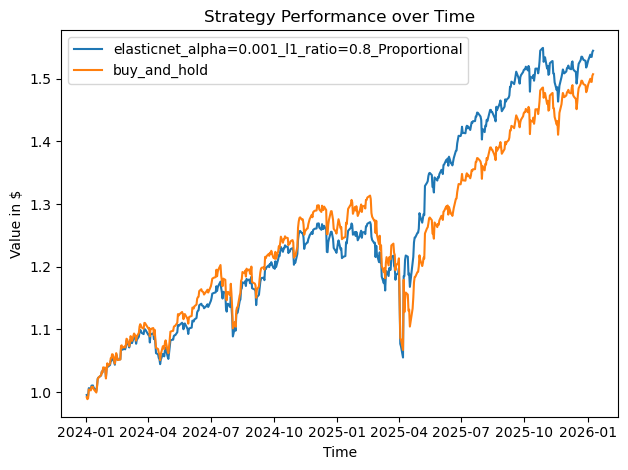

In [56]:
for strat_name, strat_df in portfolio_output.items():
    cumulative = np.exp(strat_df["Portfolio Returns"].cumsum())
    plt.plot(strat_df.index, cumulative, label=f"{strat_name}")

for benchmark_name, benchmark_df in benchmark_output.items():
    cumulative = np.exp(benchmark_df["Portfolio Returns"].cumsum())
    plt.plot(benchmark_df.index, cumulative, label=f"{benchmark_name}")

plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Value in $")
plt.title("Strategy Performance over Time")
plt.tight_layout()

This plot shows what would happen to $\$1$ at the beginning of 2024 if we utilized our `elasticnet_alpha=0.001_l1_ratio=0.8_Proportional` strategy. $\$1$ in 2024 would become $\approx\$1.6$.

The orange line represents the buy-and-hold strategy. The strategy is as the name suggests - you buy a dollar's worth of SPY, and just let that sit. This is often used as a benchmark to evaluate our strategies relative to. After all, it's just the SPY return plotted on the axes. 

Our strategy did better than Buy-and-Hold in terms of total return. Buy-and-Hold turned $\$1$ into around $\$1.5$.

---

In [57]:
portfolio_output['elasticnet_alpha=0.001_l1_ratio=0.8_Proportional']['Leverage'].mean()

0.901595155964591

In [58]:
for benchmark_name, benchmark_df in benchmark_output.items():
    cumulative = np.exp(benchmark_df["Portfolio Returns"].cumsum())
    print(cumulative.iloc[-1])

1.5071301694166592


In [59]:
for strat_name, strat_df in portfolio_output.items():
    cumulative = np.exp(strat_df["Portfolio Returns"].cumsum())
    print(cumulative.iloc[-1])

1.5445955729021479


## 6. Conclusion and Next Questions
So what do we conclude - is our strategy a good one or not? Well, on the out-of-sample data, our strategy has a Sharpe Ratio of 1.37 and a max drawdown of 0.17. Also, based on the total return, our strategy outperformed the Buy-and-Hold strategy by converting $\$1$ invested at the beginning of 2024 into an amount roughly 2.4% more than that achieved by the Buy-and-Hold strategy. Finally, the simple numbers above show us that on average, 90% of our portfolio was invested in the SPY (i.e. the leverage we assigned was 0.9 on average). And yet our total return is 2.4% higher than traditional Buy-and-Hold. These numbers are reflective of a good strategy.

But let's not get too hasty and start trading this strategy - we must take into account all of the things that we haven't accounted for in this workflow. For one thing, the out-of-sample data contains only 509 days. In short time spans, Sharpe Ratios tend to be inflated because there isn't enough time for volaility to be large. So can we trust this Sharpe Ratio? Additionally, we haven't accounted for things like transaction costs. These can definitely prove to be a siginificant detractor from the returns we generate (and could very well eat up the additional 2.4% total return we've generated).

Finally, there are two more steps that are useful to take to prove that our frozen strategy after the in-sample excellence phase is not overfitting. These steps are the in-sample permutation test and the walk-forward permutation test. These tests involve permuting the actual dataset and creating multiple synthetic datasets. We perform in-sample excellence on these permutations and judge the performance of our strategy on them. Our null hypothesis is that we are overfitting, and we are seeking statistical evidence to reject it. If our strategy appears to perform as well or better on the fake datasets as compared to the actual dataset, then this means it is probably overfitting in some capacity. However, if it doesn't perform as well as it did on the actual dataset, then it probably means that it found some patterns in the real data that it took advantage of, and this gives us evidence to reject the null hypothesis.

So the workflow illustrated here is very good as an initial step. It now needs to be extended in the aforementioned ways.